In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
import seaborn as sns

In [20]:
df_final = pd.read_csv('datos_futures_B.csv')

                Modelo  Precision  Recall  F1-Score     AUC
0        Random Forest     0.7626  0.9122    0.8307  0.9125
1              XGBoost     0.8370  0.9020    0.8683  0.9444
2  Logistic Regression     0.6449  0.7522    0.6944  0.7706
3                  SVM     0.7969  0.8769    0.8350  0.9112


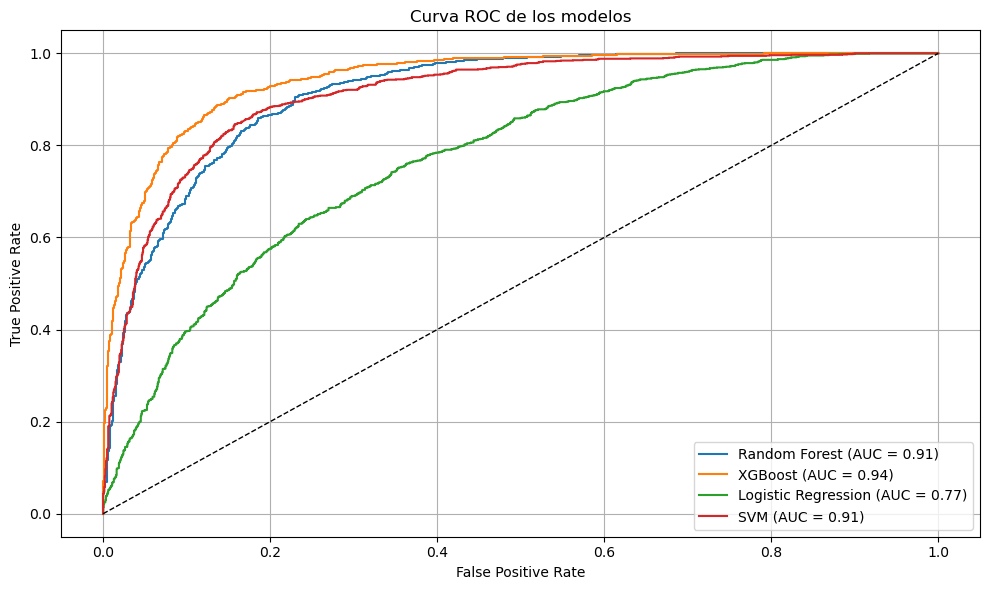

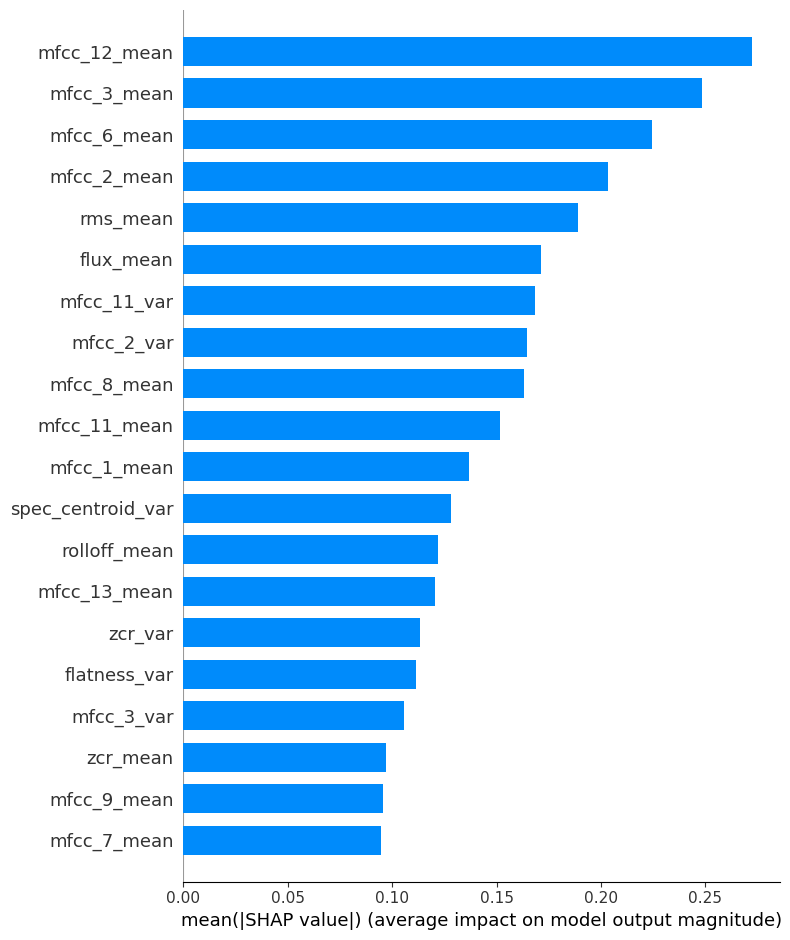

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
import seaborn as sns

df_final = pd.read_csv('datos_futures_M1.csv')

df_final['is_ave'] = df_final['is_ave'].astype(bool).astype(int)
X = df_final.drop(columns=['is_ave'])
y = df_final['is_ave']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)  # type: ignore

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal) # type: ignore
X_test_scaled = scaler.transform(X_test)

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,                 
        min_samples_leaf=5,          
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        reg_alpha=0.5,               # L1 regularización
        reg_lambda=1.0,              # L2 regularización
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        penalty='l2',                # L2 regularización (ridge)
        C=0.5,                       # menor C => más regularización
        solver='liblinear',
        max_iter=1000,
        random_state=42
    ),
    "SVM": SVC(
        kernel='rbf',
        C=0.5,                       # menor C => más margen, menos sobreajuste
        probability=True,
        random_state=42
    )
}

resultados = []

def evaluar(nombre, y_test, y_pred, y_proba):
    resultados.append({
        'Modelo': nombre,
        'Precision': round(float(precision_score(y_test, y_pred)), 4),
        'Recall': round(float(recall_score(y_test, y_pred)), 4),
        'F1-Score': round(float(f1_score(y_test, y_pred)), 4),
        'AUC': round(float(roc_auc_score(y_test, y_proba)), 4)
    })

for nombre, modelo in models.items():
    if nombre in ['Logistic Regression', 'SVM']:
        modelo.fit(X_train_scaled, y_train_bal)
        y_pred = modelo.predict(X_test_scaled)
        y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    else:
        modelo.fit(X_train_bal, y_train_bal)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)[:, 1]
        
    evaluar(nombre, y_test, y_pred, y_proba)

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))

for nombre, modelo in models.items():
    if nombre in ['Logistic Regression', 'SVM']:
        y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = modelo.predict_proba(X_test)[:, 1]
        
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc:.2f})")

# Diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC de los modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Para Random Forest
importances_rf = models['Random Forest'].feature_importances_
# Para XGBoost
importances_xgb = models['XGBoost'].feature_importances_

# Explicador de SHAP para XGBoost
explainer = shap.Explainer(models['XGBoost'])
shap_values = explainer(X_test)

# Gráfico de resumen de importancia global
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [29]:
explainer_rf = shap.Explainer(models['Logistic Regression'])
shap_values_rf = explainer_rf(X_test)
shap.summary_plot(shap_values_rf, X_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression(C=0.5, max_iter=1000, random_state=42, solver='liblinear')

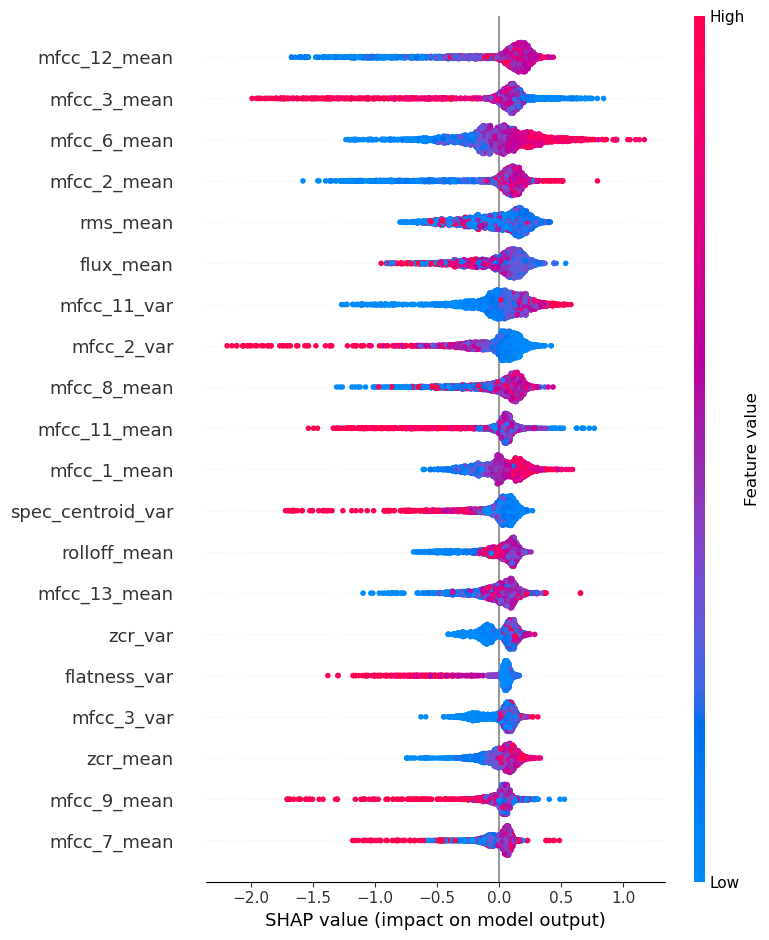

In [23]:
shap.summary_plot(shap_values, X_test)


In [24]:
importances_rf = models['Random Forest'].feature_importances_
importances_rf

array([0.03442324, 0.04151201, 0.06205543, 0.02638824, 0.02263568,
       0.04200479, 0.01766233, 0.03268658, 0.02796883, 0.02129823,
       0.03458149, 0.05526603, 0.02647841, 0.01239305, 0.02739089,
       0.01073653, 0.01155227, 0.01045543, 0.01080529, 0.0122803 ,
       0.0113222 , 0.01696251, 0.01169688, 0.03145711, 0.01809889,
       0.02130854, 0.04588284, 0.02748368, 0.01846809, 0.01561266,
       0.04648156, 0.01847907, 0.028528  , 0.02186884, 0.01919819,
       0.03013454, 0.02592175, 0.01106982, 0.03616374, 0.00328605])

In [25]:
from scipy.special import expit  # sigmoid para SVM
import pandas as pd

# Cargar los features del nuevo audio
df_new = pd.read_csv('ave.csv')  
df_new_scaled = scaler.transform(df_new)  


def decode_label(pred):
    return ['Ave' if p > 0.7 else 'No Ave' for p in pred]


pred_rf = models['Random Forest'].predict(df_new)
proba_rf = models['Random Forest'].predict_proba(df_new)[:, 1]


pred_xgb = models['XGBoost'].predict(df_new)
proba_xgb = models['XGBoost'].predict_proba(df_new)[:, 1]


pred_log = models['Logistic Regression'].predict(df_new_scaled)
proba_log = models['Logistic Regression'].predict_proba(df_new_scaled)[:, 1]


pred_svm = models['SVM'].predict(df_new_scaled)
proba_svm = expit(models['SVM'].decision_function(df_new_scaled))

results_df = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM'],
    'Predicción': decode_label([pred_rf[0], pred_xgb[0], pred_log[0], pred_svm[0]]),
    'Probabilidad Ave': [
        round(proba_rf[0], 3),
        round(proba_xgb[0], 3),
        round(proba_log[0], 3),
        round(proba_svm[0], 3)
    ]
})

print(results_df)

                Modelo Predicción  Probabilidad Ave
0        Random Forest        Ave             0.563
1              XGBoost     No Ave             0.497
2  Logistic Regression     No Ave             0.270
3                  SVM        Ave             0.546
